# DD2424 - Project
This is an altered version of the method presented in NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis

[Project website](http://www.matthewtancik.com/nerf)

Components not included in the notebook

* 5D input including view directions
* Hierarchical Sampling

In [1]:
"""
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x
"""
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [57]:
tf.random.set_seed(0)
a = tf.random.uniform((10, 5), minval=-1, maxval=1)
b =tf.split(a, 2, 0)
print(b)
# inputs = tf.random.uniform((10, 5), minval=-5, maxval=5)

# digest = tf.matmul(inputs, a)
# digest = tf.cast(tf.greater(digest, 0), dtype=tf.int32)
# keys = tf.reduce_sum(digest * 2 ** tf.range(0, 5), axis=1)

# uniques, idx = tf.unique(keys)
# print(uniques)
# def find(u):
#     return tf.gather(inputs, tf.where(tf.equal(keys, u)))
# def calc(c):
#     return tf.reduce_mean(c, axis=0, keepdims=True)

# # clusters = [inputs[keys==u] for u in uniques]
# clusters = tf.map_fn(find, uniques, dtype=tf.float32)
# cluster_centers = tf.concat([tf.reduce_mean(c, axis=0, keepdims=True) for c in clusters], axis=0)
# hashed = tf.squeeze(cluster_centers)
# print(inputs)
# print("-"*70)
# print(hashed)
# hashed *= 2
# print(hashed)
# for c, h in zip(clusters, hashed):
#     print(c.shape)
#     print(h.shape)
#     print("-"*70)
# dehashed = tf.concat([tf.tile(tf.reshape(h, (1,h.shape[0])), (c.shape[0],1)) for c, h in zip(clusters, hashed)], axis=0)
# print(dehashed)


[<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[-0.41604972, -0.5868671 ,  0.07078147,  0.12251496, -0.16665101],
       [ 0.6156559 , -0.0135498 ,  0.9962585 ,  0.3934703 , -0.7492528 ],
       [ 0.4196334 ,  0.32483125,  0.14451313, -0.27049303, -0.15896344],
       [ 0.26011395,  0.827626  ,  0.3232944 ,  0.6669471 , -0.83208394],
       [-0.4404812 , -0.9689536 ,  0.4527471 ,  0.5310774 ,  0.35973334]],
      dtype=float32)>, <tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 0.06545591,  0.51302814, -0.90515614, -0.8992572 ,  0.5034869 ],
       [-0.6545744 , -0.37612963, -0.4172523 , -0.7989752 , -0.6686585 ],
       [ 0.53933024,  0.17135954,  0.9640193 ,  0.8296654 , -0.7166693 ],
       [-0.80486894,  0.21255684, -0.64415646,  0.03610396,  0.9642422 ],
       [-0.6484411 , -0.9087367 ,  0.1950829 ,  0.12590861,  0.61014867]],
      dtype=float32)>]


In [23]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [3]:
from tensorflow.python.client import device_lib
"""
Checks what gpu has been allocated
"""
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13220084209265104190,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7834603698010128574
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9851686080
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4420922555143799920
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4990683316910108099
 physical_device_desc: "device: XLA_GPU device"]

# Load input images and poses. 
The input images have size (100,100,3)

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


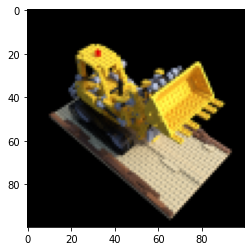

In [2]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# NeRF network

In [3]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

L_embed = 6
embed_fn = posenc




In [5]:


def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


class MLP(tf.keras.layers.Dense):
    def __init__(self, W, activation, H=8, CR=False):
      super(MLP, self).__init__(W, activation=activation)
      
      # self.cls_map = tf.lookup.experimental.DenseHashTable(key_dtype=tf.int32,
      #                            value_dtype=tf.float32,
      #                            default_value=-1,
      #                            empty_key=-2,
      #                            deleted_key=-1)

      self.cls_map = {}
      self.H = H
      self.CR = CR

    def build(self, inputs):
      super(MLP, self).build(inputs)
      self.hash_mat = tf.random.uniform((inputs[1],self.H), minval=-1, maxval=1)
      #self.hash_func = [self.hash_(tf.random.uniform((inputs.dims[1],1), minval=-1, maxval=1)) for _ in range(H)]
    
    
    # def call(self, inputs): 
    #   def func(vec):
    #     vec = tf.reshape(vec, (1, vec.shape[0]))
    #     digest = tf.matmul(vec, self.hash_mat)
    #     digest = tf.cast(tf.math.greater(digest, 0), dtype=tf.int32)
    #     key = tf.reduce_sum(digest * 2 ** tf.range(0, vec.shape[0], dtype=tf.int32))
    #     y = self.cls_map.lookup(key)
        
    #     def in_table(): return y
    #     def not_in_table():
    #       y2 = super(MLP, self).call(vec)
    #       return y2

    #     outputs = tf.cond(tf.math.not_equal(y, -1), in_table, not_in_table)
    #     return outputs
      
    #   # digest = tf.matmul(inputs, self.hash_mat)
    #   # digest = tf.cast(tf.math.greater(digest, 0), dtype=tf.int32)
    #   #digest = tf.strings.as_string(digest)
     
    #   #idx = tf.where(tf.math.equal(self.cls_map.lookup(digest), -1))
    #   #idx2 = tf.where(tf.math.not_equal(self.cls_map.lookup(digest), -1))
    #   #y = super(MLP, self).call(inputs[idx])
    #   #self.cls_map.insert(digest[idx], y)

    #   outputs = tf.reshape(tf.map_fn(func, inputs, dtype=tf.float32), (-1, inputs.shape[1]))
    #   return outputs
    #   #return tf.py_function(self.reuse, [inputs], tf.float32)
    #   #bit_mat = np.concatenate([self.hash_func[h](inputs) for h in range(self.H)], )
    #     # return super(MLP, self).call(inputs)

    def call(self, inputs):
      def hash_(vec):
        # keys = np.sum(vec * 2 ** np.arange(vec.shape[1]), axis=0)
        vec.numpy().shape()
        idx = np.asarray([i in self.cls_map for i in vec.numpy()], dtype=np.int)
        idx_e = np.where(idx==1)[0]
        idx_n = np.where(idx==0)[0]
        out = [self.cls_map[i] for i in idx_e]
        return [out, idx_n]
      
      def store(idx, y):
        for i in range(len(idx)):
          self.cls_map[i] = y[i]


      digest = tf.matmul(inputs, self.hash_mat)
      digest = tf.cast(tf.math.greater(digest, 0), dtype=tf.int32)
      keys = tf.reduce_sum(digest * 2 ** tf.range(0, digest.shape[1], dtype=tf.int32))
      out, idx = tf.py_function(hash_, [keys], (tf.float32, tf.int32))
      y = super(MLP, self).call(tf.gather(inputs, idx, axis=0))
      tf.py_function(store, [idx, y], Tout=[])
      return tf.concat([out, y], axis=0)

class neRF(tf.keras.Model):
  def init_model(self, D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : MLP(W, activation=act, H=self.H, CR=self.CR)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    return inputs, outputs
  


  def __init__(self, H=8, CR=False):
    self.H = H
    self.CR = CR
    inputs, outputs = self.init_model()
    super(neRF, self).__init__(inputs=inputs, outputs=outputs)
  
  def call(self, inputs):
    return super(neRF, self).call(inputs)

    

# Main function
render_rays() takes the model and a ray as input. Draw N_samples of points alone the ray. Run the network on these points, use the output to compute the the color and opacity(density). 

In [7]:
def render_rays_profile(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    pr = cProfile.Profile()
    pr2 = cProfile.Profile()
    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    
    pr.enable()
    raw = batchify(network_fn)(pts_flat)
    pr.disable()
    ps = pstats.Stats(pr).sort_stats('tottime').dump_stats("[Profile]forward")
    
    raw = tf.reshape(raw, list(shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    pr2.enable()
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)
    pr2.disable()
    ps = pstats.Stats(pr2).sort_stats('tottime').dump_stats("[Profile]rendering")
    
    return rgb_map, depth_map, acc_map

In [6]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    def batchify(fn, chunk=1024*32):
      return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    shape = pts_flat.shape
    clus = CLS(pts_flat.shape[1])
    pts_flat = clus.hash(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = clus.dehash
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)
    
    return rgb_map, depth_map, acc_map

In [8]:

# def cluster(input):
#   kmeans = KM(input.shape[0]//4,  random_state=0, batch_size=10)
#   kmeans = kmeans.fit(input)
#   return kmeans.cluster_centers_

class CLS():
  def __init__(self, N):
    self.set(N)

  def hash(self, inputs):
    digest = tf.matmul(inputs, self.hash_mat)
    digest = tf.cast(tf.greater(digest, 0), dtype=tf.int32)
    keys = tf.reduce_sum(digest * 2 ** tf.range(0, self.H), axis=1)

    uniques, _ = tf.unique(keys)
    #clusters = [inputs[keys==u] for u in uniques]
    self.clusters = [tf.gather(inputs, tf.where(keys == u)) for u in uniques]
    cluster_centers = tf.concat([tf.reduce_mean(c, axis=0, keepdims=True) for c in self.clusters], axis=0)
    return tf.squeeze(cluster_centers)
  
  def dehash(self, inputs):
    outputs = tf.concat([tf.tile(tf.reshape(h, (1,h.shape[0])), (c.shape[0],1)) for c, h in zip(self.clusters, inputs)], axis=0)
    return outputs
  
    
  def set(self, N, H=8, CR=False):
    self.H = H
    self.CR = CR
    self.hash_mat = tf.keras.utils.normalize(tf.random.uniform((N,self.H), minval=-1, maxval=1), axis=0)


# Render a single image of the scene 

0 0.0263848876953125 secs per iter
PSNR: 9.304994583129883


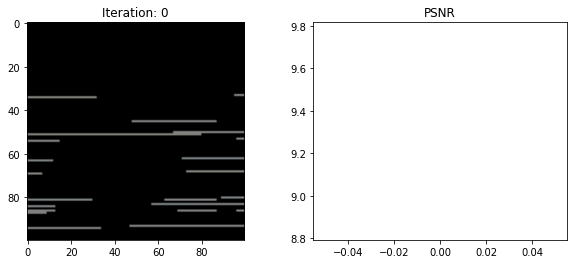

25 0.5426080989837646 secs per iter
PSNR: 9.044085502624512


<Figure size 432x288 with 0 Axes>

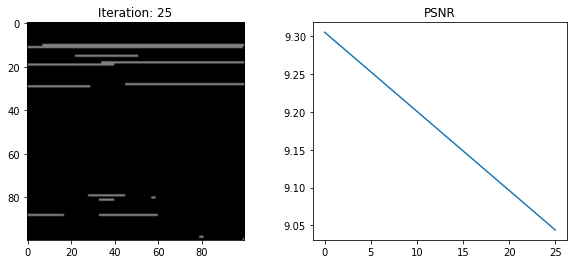

50 0.5434540557861328 secs per iter
PSNR: 9.33332347869873


<Figure size 432x288 with 0 Axes>

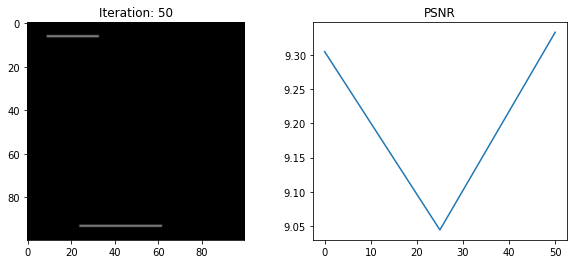

75 0.5420904445648194 secs per iter
PSNR: 9.197028160095215


<Figure size 432x288 with 0 Axes>

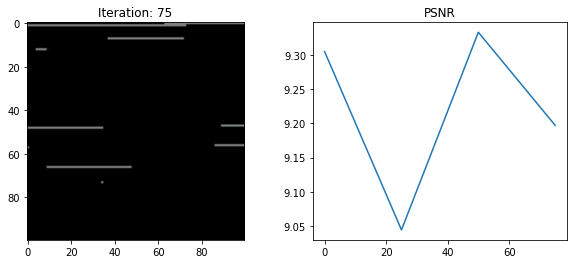

100 0.5441880512237549 secs per iter


KeyboardInterrupt: 

In [9]:
import time, cProfile, pstats
model = init_model()
#model = init_model_kmeans()
# model = neRF()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

tf.random.set_seed(0)

log = True
profile = False

t = time.time()
pr = cProfile.Profile()
pr.enable()
for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        #rgb, depth, acc = render_rays_profile(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    
    #cProfile.run("gradients = tape.gradient(loss, model.trainable_variables)", "[Profile]backprop")
    gradients = tape.gradient(loss, model.trainable_variables)

    if i%i_plot==0 and log:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        if profile:
          p = pstats.Stats('[Profile]forward')
          p.strip_dirs().sort_stats('tottime').print_stats(.01)

          p = pstats.Stats('[Profile]rendering')
          p.strip_dirs().sort_stats('tottime').print_stats(.01)

          p = pstats.Stats('[Profile]backprop')
          p.strip_dirs().sort_stats('tottime').print_stats(.01)
        # Render the holdout view for logging
        
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        print("PSNR: {}".format(psnr))
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()
        plt.savefig("PSNR_default.png")
"""
pr.disable()
ps = pstats.Stats(pr).sort_stats('tottime').dump_stats("[Profile]training")
p = pstats.Stats('[Profile]training')
p.strip_dirs().sort_stats('tottime').print_stats(.01)
model.save('nerf_default')
"""
print('Done')